Introduction: 

I'm trying to predict daily sales of a big brand with stores in the whole country. I use SARIMAX and Prophet to predict.

The dataset in from Kaggle and contains six dataframes:

 - The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- Store metadata, including city, state, type, and cluster.
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
- Holidays and Events, with metadata

In [1]:
import sys, os
os.chdir('/Users/lananhnguyen/Desktop/Projects')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [2]:
import prophet

/Users/lananhnguyen/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_df = pd.read_csv('store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('store-sales-time-series-forecasting/test.csv')
oil_df = pd.read_csv('store-sales-time-series-forecasting/oil.csv')
transaction_df = pd.read_csv('store-sales-time-series-forecasting/transactions.csv')
stores_df = pd.read_csv('store-sales-time-series-forecasting/stores.csv')
holiday_event_df = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv')

In [4]:
train_df.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [5]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [6]:
oil_df.sample(10)

,date,dcoilwtico
677,2015-08-06,44.69
545,2015-02-03,53.04
340,2014-04-22,101.69
894,2016-06-06,49.71
813,2016-02-12,29.32
410,2014-07-29,104.91
554,2015-02-16,NaN
99,2013-05-20,96.29
347,2014-05-01,99.69
1012,2016-11-17,45.37


In [7]:
transaction_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [8]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
holiday_event_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


# Prepare data
Merge tables, clean data

In [10]:
train_df = train_df.merge(stores_df, on = 'store_nbr')
train_df = train_df.merge(oil_df, on ='date', how = 'left')
holiday_event_df = holiday_event_df.rename(columns = {'type': 'holiday_type'})
train_df = train_df.merge(holiday_event_df, on = 'date', how = 'left')

In [11]:
train_df.sample(5)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
307027,1286799,2014-12-26,14,PRODUCE,370.793,0,Riobamba,Chimborazo,C,7,54.59,Additional,National,Ecuador,Navidad+1,False
1638040,2884219,2017-06-11,35,LADIESWEAR,0.000,0,Playas,Guayas,C,3,NaN,NaN,NaN,NaN,NaN,NaN
630279,429837,2013-08-30,2,GROCERY I,2665.000,0,Quito,Pichincha,D,13,107.98,NaN,NaN,NaN,NaN,NaN
2268017,297158,2013-06-16,46,PET SUPPLIES,0.000,0,Quito,Pichincha,A,14,NaN,NaN,NaN,NaN,NaN,NaN
2069968,1797454,2015-10-08,42,EGGS,88.000,1,Cuenca,Azuay,D,2,49.46,NaN,NaN,NaN,NaN,NaN


In [70]:
test_df = test_df.merge(oil_df, on ='date', how = 'left')
test_df = test_df.merge(holiday_event_df, on = 'date', how = 'left')
test_df.head()

,id,date,store_nbr,family,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,NaN,NaN,NaN,NaN,NaN
1,3000889,2017-08-16,1,BABY CARE,0,46.8,NaN,NaN,NaN,NaN,NaN
2,3000890,2017-08-16,1,BEAUTY,2,46.8,NaN,NaN,NaN,NaN,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,46.8,NaN,NaN,NaN,NaN,NaN
4,3000892,2017-08-16,1,BOOKS,0,46.8,NaN,NaN,NaN,NaN,NaN


Move on to clean data: fill missing data + remove duplicates

In [12]:
train_df.shape

(3054348, 16)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   city          object 
 7   state         object 
 8   type          object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  holiday_type  object 
 12  locale        object 
 13  locale_name   object 
 14  description   object 
 15  transferred   object 
dtypes: float64(2), int64(4), object(10)
memory usage: 396.1+ MB


In [14]:
train_df.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

We see that column oil price and holiday have missing values. To handle that:
- Interpolate column oil price
- Create a binary column for holiday as 1-holiday and 0-no holiday.

In [15]:
train_df['dcoilwtico'] = train_df['dcoilwtico'].interpolate(limit_direction = 'both')
train_df.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico            0
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [75]:
test_df['dcoilwtico'] = test_df['dcoilwtico'].interpolate(limit_direction = 'both')
test_df.isna().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
dcoilwtico          0
holiday_type    26730
locale          26730
locale_name     26730
description     26730
transferred     26730
dtype: int64

In [16]:
train_df['holiday'] = train_df['holiday_type'].notnull().astype(int)
train_df.sample(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred,holiday
2050723,774580,2014-03-12,42,BOOKS,0.000,0,Cuenca,Azuay,D,2,98.290000,NaN,NaN,NaN,NaN,NaN,0
1885179,990120,2014-07-11,4,LINGERIE,2.000,0,Quito,Pichincha,D,9,101.480000,NaN,NaN,NaN,NaN,NaN,0
1405017,2522331,2016-11-19,31,DELI,304.683,7,Babahoyo,Los Rios,B,10,45.957164,NaN,NaN,NaN,NaN,NaN,0
1995683,856523,2014-04-27,41,DAIRY,653.000,0,Machala,El Oro,D,4,101.025522,NaN,NaN,NaN,NaN,NaN,0
1869823,177517,2013-04-10,4,EGGS,148.000,0,Quito,Pichincha,D,9,94.590000,NaN,NaN,NaN,NaN,NaN,0
755062,1050049,2014-08-14,21,"LIQUOR,WINE,BEER",0.000,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6,95.540000,NaN,NaN,NaN,NaN,NaN,0
95994,2101041,2016-03-28,10,PRODUCE,181.215,0,Quito,Pichincha,C,15,37.990000,NaN,NaN,NaN,NaN,NaN,0
2185335,1918695,2015-12-15,44,DELI,457.050,0,Quito,Pichincha,A,5,37.320000,NaN,NaN,NaN,NaN,NaN,0
45520,2414623,2016-09-20,1,GROCERY II,17.000,0,Quito,Pichincha,D,13,43.850000,NaN,NaN,NaN,NaN,NaN,0
520841,629345,2013-12-20,18,BEAUTY,0.000,0,Quito,Pichincha,B,16,99.110000,NaN,NaN,NaN,NaN,NaN,0


In [76]:
test_df['holiday'] = test_df['holiday_type'].notnull().astype(int)

In [17]:
train_df['date']= pd.to_datetime(train_df['date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  holiday_type  object        
 12  locale        object        
 13  locale_name   object        
 14  description   object        
 15  transferred   object        
 16  holiday       int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(9)
memory usage: 419.5+ MB


In [77]:
test_df['date']= pd.to_datetime(test_df['date'])

In [18]:
# create new columns 'month' 'year'
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year

Duplicates

In [19]:
train_df.duplicated().any()

False

In [20]:
test_df.duplicated().any()

False

# Quick EDA

In [21]:
train_df.describe()

,id,store_nbr,sales,onpromotion,cluster,dcoilwtico,holiday,month,year
count,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,1.504277e+06,2.750000e+01,3.590209e+02,2.617480e+00,8.481481e+00,6.781156e+01,1.645274e-01,6.222870e+00,2.014842e+03
std,8.662610e+05,1.558579e+01,1.107286e+03,1.225494e+01,4.649735e+00,2.567612e+01,3.707535e-01,3.374251e+00,1.345607e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,0.000000e+00,1.000000e+00,2.013000e+03
25%,7.546768e+05,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.632000e+01,0.000000e+00,3.000000e+00,2.014000e+03
50%,1.507572e+06,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.329130e+01,0.000000e+00,6.000000e+00,2.015000e+03
75%,2.255120e+06,4.100000e+01,1.960110e+02,0.000000e+00,1.300000e+01,9.576821e+01,0.000000e+00,9.000000e+00,2.016000e+03
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,1.000000e+00,1.200000e+01,2.017000e+03


## Questions

1. Does the type of stores affect the store sales? 

2. Which family is having the highest sales? 

3. Does promotion able to improve the sales? 

#1.

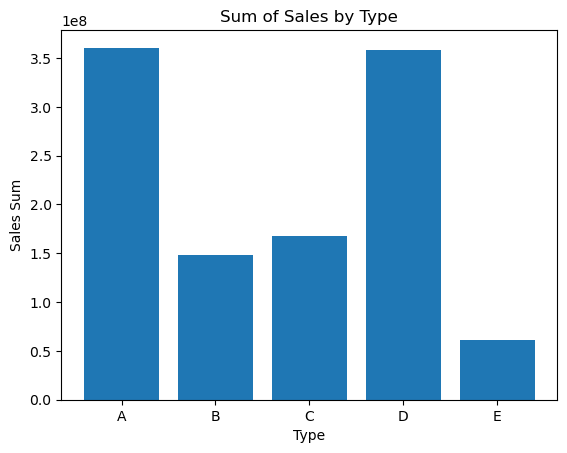

In [22]:
sales_sum_by_type = train_df.groupby('type')['sales'].sum()
plt.bar(sales_sum_by_type.index, sales_sum_by_type.values)
plt.xlabel('Type')
plt.ylabel('Sales Sum')
plt.title('Sum of Sales by Type')
plt.show()

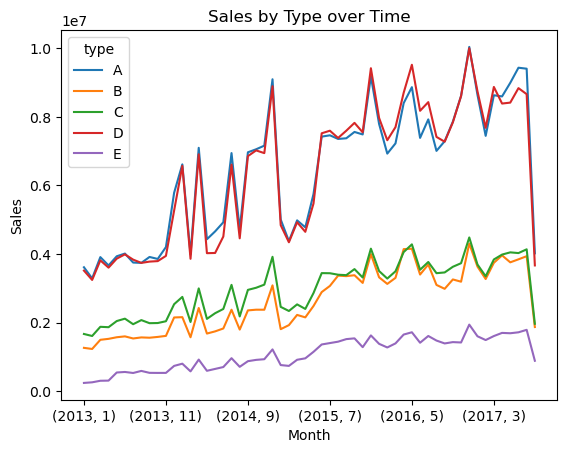

In [23]:
#group by month and year
monthly_sales_by_type = train_df.groupby(['year','month', 'type'])['sales'].sum()

# Unstack 'type' to have types as columns
pivot_df = monthly_sales_by_type.unstack(level='type')

# Plot the time series for each type
pivot_df.plot()

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by Type over Time')

# Display the plot
plt.show()

Answer: Types of stores affect the sales. Here we can see type A and D have highest sales throughout the period, then type C, B and lastly type E.

2. Which family is having the highest sales? 

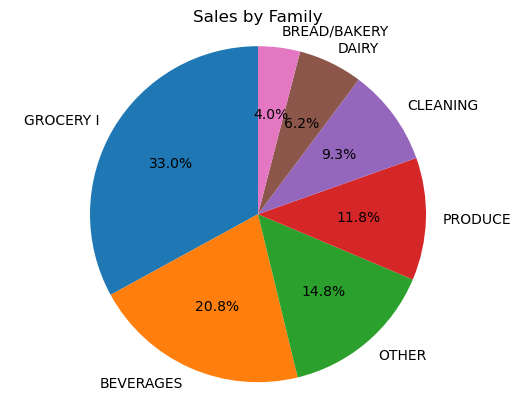

In [24]:
#Pie chart
# Group the data by family and calculate the total sales for each family
family_sales = train_df.groupby('family')['sales'].sum().sort_values(ascending=False)
family_sales['OTHER'] = family_sales.iloc[7:].sum()
family_sales = family_sales.sort_values(ascending = False).head(7)

# Create the pie chart
plt.pie(family_sales, labels=family_sales.index, autopct='%1.1f%%', startangle=90)

plt.title('Sales by Family')

plt.axis('equal')  
plt.show()

The Grocery I is having the highest sales, and Baverages comes second highest.

3. Does promotion able to improve the sales?¶

H0 (>0.05)= The promotion does not affect store sales.

H1 (<0.05)= The promotion does affect store sales.

In [25]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(train_df['onpromotion'], train_df['sales'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.4282410665296732
p-value: 0.0


Based on the Pearson correlation coefficient of 0.4279 and the p-value of 0.0, we can reject the null hypothesis (H0) and conclude that there is a significant relationship between promotion and store sales. Therefore, the promotion does affect store sales.

# SARIMAX

Since we combine the sales all together, columns that matter are holiday, oil price and on promotion.

In [79]:
daily_sales = train_df.groupby('date')[['sales', 'holiday', 'onpromotion']].sum()
daily_sales['oil_price'] = train_df.groupby('date')['dcoilwtico'].mean()
daily_sales.loc[daily_sales['holiday'] > 0, 'holiday'] = 1
daily_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-01,2511.618999,1,0,70.776944
2013-01-02,496092.417944,0,0,93.140000
2013-01-03,361461.231124,0,0,92.970000
2013-01-04,354459.677093,0,0,93.120000
2013-01-05,477350.121229,1,0,93.140299


In [110]:
# For test df

daily_sales_t = test_df.groupby('date')[['holiday', 'onpromotion']].sum()
daily_sales_t['oil_price'] = test_df.groupby('date')['dcoilwtico'].mean()
daily_sales_t.loc[daily_sales_t['holiday'] > 0, 'holiday'] = 1
daily_sales_t = daily_sales_t.reset_index()
daily_sales_t.head()

,date,holiday,onpromotion,oil_price
0,2017-08-16,0,30539,46.800000
1,2017-08-17,0,7505,47.070000
2,2017-08-18,0,13777,48.590000
3,2017-08-19,0,8614,48.289916
4,2017-08-20,0,9513,47.690084


In [114]:
daily_sales_t.shape

(16, 4)

<Axes: >

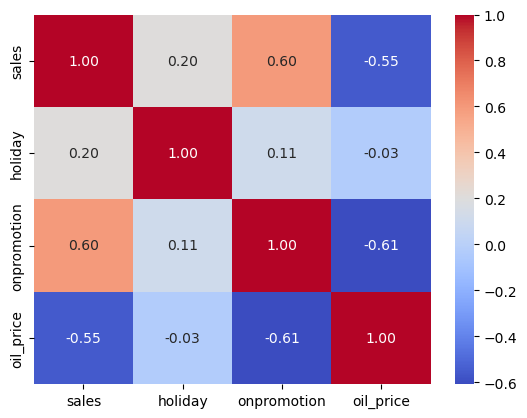

In [29]:
# Create a heat map
correlation_matrix = daily_sales.corr()

# Create a heat map of the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")


All variables included seem to have high correlation with sales, so we should include them all.

After snooping down there trying to come up with good models, I realised that the date column is missing Chrismas date :))))) I'm just speechless. 

In [30]:
daily_sales = daily_sales.asfreq('D')
daily_sales[daily_sales.isnull().any(axis=1)]

,sales,holiday,onpromotion,oil_price
date,,,,
2013-12-25,NaN,NaN,NaN,NaN
2014-12-25,NaN,NaN,NaN,NaN
2015-12-25,NaN,NaN,NaN,NaN
2016-12-25,NaN,NaN,NaN,NaN


We can assume that on Chrismas the stores are closed so there's no sales.

In [31]:
# Fill NaN value

daily_sales = daily_sales.asfreq('D')
daily_sales['sales'] = daily_sales['sales'].fillna(0)
daily_sales['holiday'] = daily_sales['holiday'].fillna(1)
daily_sales['onpromotion'] = daily_sales['onpromotion'].fillna(0)

# oil_price:
daily_sales['oil_price'] = daily_sales['oil_price'].interpolate(limit_direction = 'both')

daily_sales.isna().sum()

sales          0
holiday        0
onpromotion    0
oil_price      0
dtype: int64

For SARIMAX model, we need to visualize to have a feel of our time series, as well as try to detect any seasonality and/or nonstationarity.

In [32]:
monthly_sales = daily_sales.resample('M').sum()
monthly_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-31,1.032762e+07,3.0,0.0,2913.506944
2013-02-28,9.658960e+06,2.0,0.0,2672.080000
2013-03-31,1.142850e+07,1.0,0.0,2890.360000
2013-04-30,1.099346e+07,5.0,0.0,2754.140000
2013-05-31,1.198556e+07,4.0,0.0,2935.748250


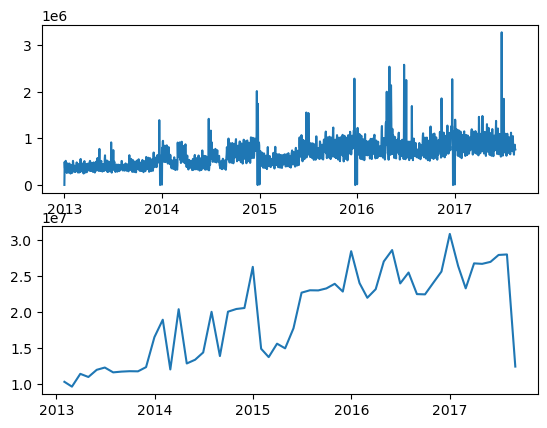

In [33]:
fig, axes = plt.subplots(2,1)
axes[0].plot(daily_sales['sales'])
axes[1].plot(monthly_sales['sales'])

There is an increasing trend in November and December, then followed by dips in January and Feburary next year.

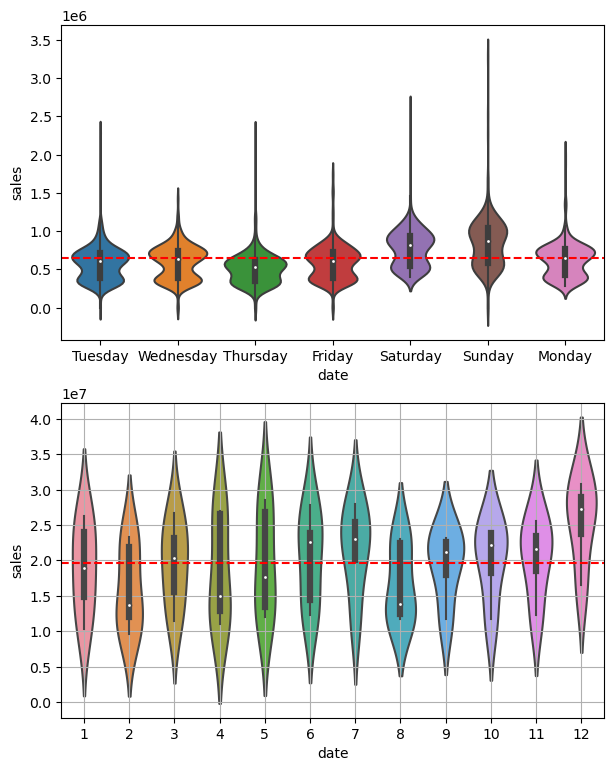

In [34]:
# violinplot of days of week and month to determine variance and range

days_of_week = daily_sales.index.day_name()

fig,axes = plt.subplots(2,1,figsize = (7, 9))
sns.violinplot(x=days_of_week, y=daily_sales['sales'], ax=axes[0])
axes[0].axhline(daily_sales['sales'].mean(), color='red', linestyle='--')

sns.violinplot(x=monthly_sales.index.month, y=monthly_sales['sales'], ax = axes[1])
axes[1].axhline(monthly_sales['sales'].mean(), color='red', linestyle='--')
plt.grid(True)
plt.show()

For days of the week, it is clear that Saturday and Sunday sales are highest and most varied, as the violins are longest and thinnest.

For monthly data, December have highest sales as expected, but July surprisingly comes in second.

But the differences are not as significant as I thought.

In [35]:
autocorr_values = daily_sales['sales'].autocorr()
print("Autocorrelation:", autocorr_values) #large autocorr -> can be AR model

Autocorrelation: 0.600319302206319


In [36]:
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,) #call function adfuller 
    dfoutput = pd.Series(dftest[0:4],  
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    # display first 4 values with its name
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) #5th value is the CV
    
dftest(daily_sales.sales)

Test Statistic            -2.723700
p-value                    0.070026
Lags Used                 22.000000
Observations Used       1665.000000
Critical Value (1%)       -3.434284
Critical Value (5%)       -2.863277
Critical Value (10%)      -2.567695
dtype: float64


Since p-value = 0.07, time series has unit root I(1) on 5% level, and therefore not stationary.

In [37]:
# define helper plot function for visualization

def plots(data, lags=None):
    plt.figure(figsize=(15, 4))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    plot_acf(data, lags=lags, ax=acf, zero=False)
    plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

/Users/lananhnguyen/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


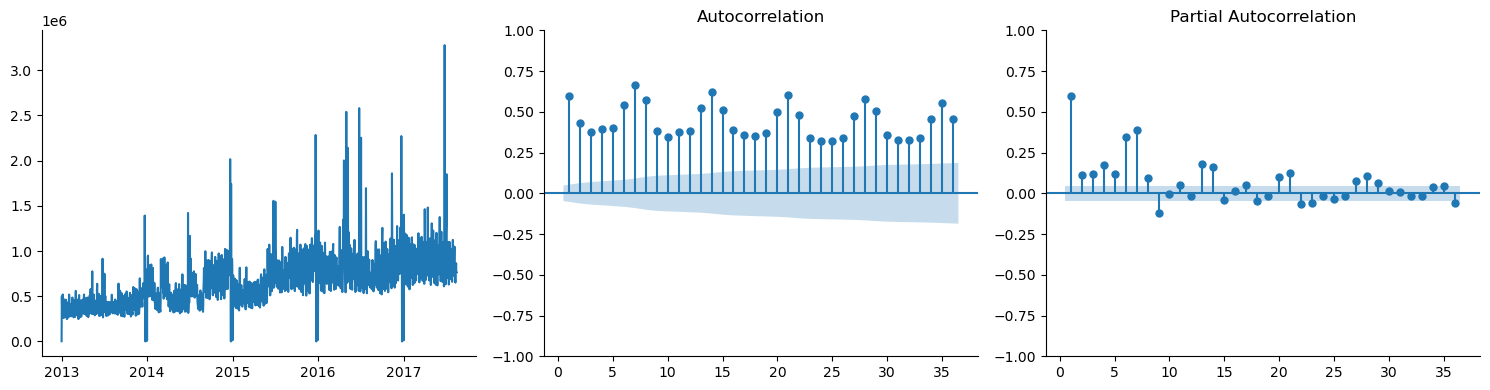

In [38]:
plots(daily_sales['sales'], lags = 36)

My guess: Since acf has high values at every 6, 7 and 8 lags
-> seasonal components every week.
There's a decay but never go to 0 -> ARMA model

/Users/lananhnguyen/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


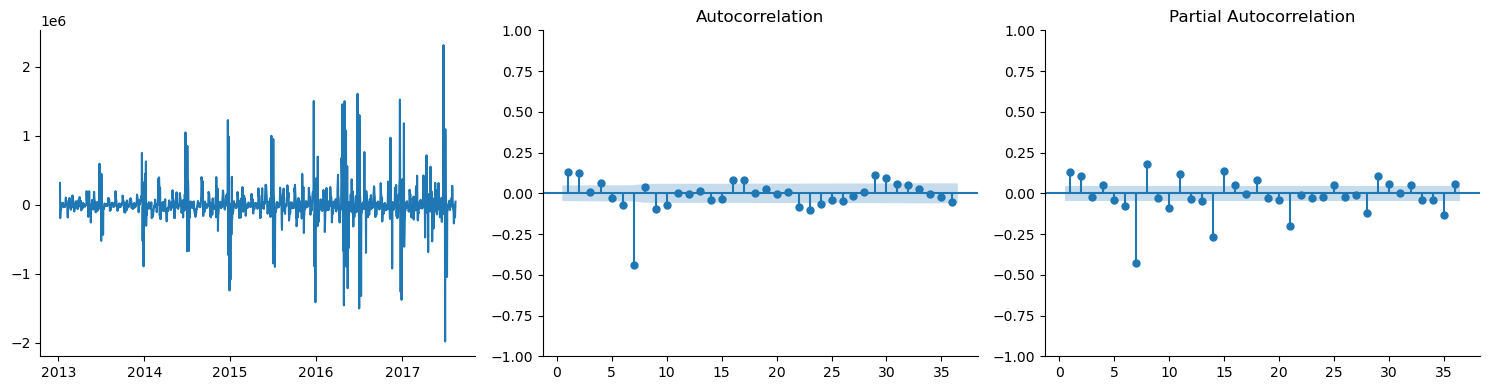

In [39]:
daily_sales['weekly_diff'] = daily_sales['sales'].diff(7)
plots(daily_sales.weekly_diff.dropna(), lags=36);

My observations: after remove weekly autocorrelation, there is no more trend and it looks like AR(2) model. 

Let's test whether weekly differencing time series is I(0) or I(1).

In [40]:
dftest(daily_sales.weekly_diff.dropna())

Test Statistic         -1.227378e+01
p-value                 8.522970e-23
Lags Used               2.000000e+01
Observations Used       1.660000e+03
Critical Value (1%)    -3.434295e+00
Critical Value (5%)    -2.863283e+00
Critical Value (10%)   -2.567698e+00
dtype: float64


p-value is so small we can be sure that time series doesn't have unit root I(1) and be stationarity.

In [41]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(daily_sales['sales'], 
                               exog=daily_sales[['holiday', 'onpromotion', 'oil_price']],
                            start_p=2, start_q=0,
                           max_p=3, max_q=2, m=7, # p,q = 1, 2, 3 
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=46228.751, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=45859.970, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=45583.078, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=46226.860, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=46206.371, Time=0.08 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=45869.562, Time=0.21 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=3.03 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=45655.884, Time=0.56 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=45528.434, Time=0.82 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=46190.138, Time=0.21 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=inf, Ti

In [42]:
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print('order: ',order)
print('seasonal order: ',seasonal_order)

order:  (1, 0, 1)
seasonal order:  (0, 1, 1, 7)


In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# fit SARIMA based on helper plots
sar = SARIMAX(daily_sales['sales'], 
              exog=daily_sales[['holiday', 'onpromotion', 'oil_price']], #Exclude  'transactions'
                order=order,
                seasonal_order=seasonal_order, #(P, Q, D)
                trend='c').fit()
sar.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31410D+01    |proj g|=  6.90732D-02


 This problem is unconstrained.



At iterate    5    f=  1.31166D+01    |proj g|=  6.45750D-03

At iterate   10    f=  1.31161D+01    |proj g|=  1.58467D-03

At iterate   15    f=  1.31154D+01    |proj g|=  5.06399D-03

At iterate   20    f=  1.31144D+01    |proj g|=  3.09562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     26      1     0     0   7.620D-06   1.311D+01
  F =   13.114368162432049     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1688
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -22137.053
Date:                           Fri, 30 Jun 2023   AIC                          44290.107
Time:                                   21:48:02   BIC                          44333.524
Sample:                               01-01-2013   HQIC                         44306.189
                                    - 08-15-2017                                         
Covariance Type:                             opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    -653.0705    553.672     -1.180      0.238   -1738.247     432.106
holiday      5.724e+04   1.04e+04      5.480      0.000    3.68e+04    7.77e+04
onpromotion    75.3053      1.227     61.359      0.000      72.900      77.711
oil_price     486.7429   2403.597      0.203      0.840   -4224.221    5197.706
ar.L1           0.8588      0.021     41.264      0.000       0.818       0.900
ma.L1          -0.4696      0.033    -14.291      0.000      -0.534      -0.405
ma.S.L7        -0.8146      0.019    -43.182      0.000      -0.852      -0.778
sigma2       2.309e+10      0.099   2.33e+11      0.000    2.31e+10    2.31e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):             24114.62
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             1.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+26. Standard errors may be unstable.
"""

Look at second table, pay attention to column P>|z|. If p-value (P>|z|) is small (typically below a significance level like 0.05), it suggests that the coefficient is statistically significant, and there is evidence to reject the null hypothesis that the true coefficient is zero. We see that only oil price coefficient is not statistically significant (p-value = 0.898), other variables are statistically significant.

/Users/lananhnguyen/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


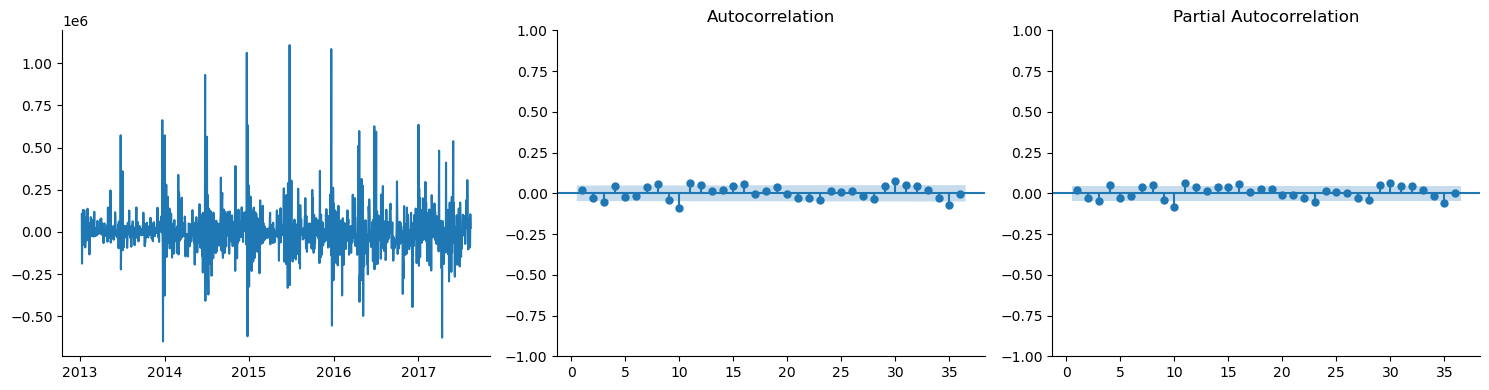

In [44]:
#plot the residuals

plots(sar.resid[sar.loglikelihood_burn:], lags=36); #loglikelihood_burn: is using loglikelihood and we don't use some first few obs

Actually it looks quite decent, I'm satisfied with the result. I don't think we need to increase the AR and MA lags.

In [45]:
daily_sales.shape

(1688, 5)

Now pick out some tail observations for prediction: 

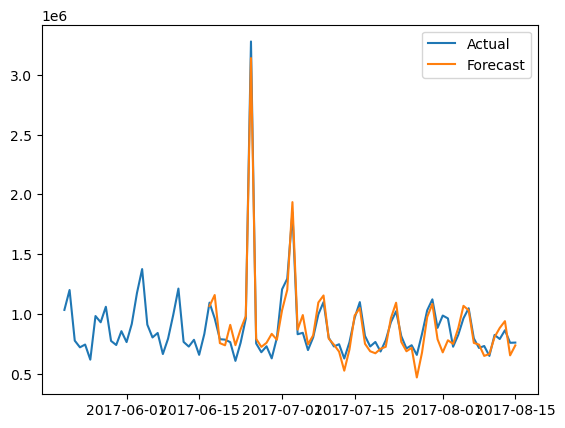

In [46]:
# Select the last 60 days of data for comparison
last_60_days = daily_sales.iloc[-60:]

# Extract the exogenous variables for the last 60 days
exog_data = last_60_days[['holiday', 'onpromotion', 'oil_price']]

# Get the forecast for the next 60 days, including exogenous variables
forecast = sar.get_prediction(start=last_60_days.index[0], end=last_60_days.index[-1], exog=exog_data)

# Extract the predicted values for the next 60 days
predicted_values = forecast.predicted_mean

# Plot the actual sales and predicted values
plt.plot(daily_sales[1600:]['sales'], label = 'Actual')
plt.plot(predicted_values.index, predicted_values, label='Forecast')
plt.legend()
plt.show()


It looks pretty good, SARIMA model can pick up the trend quite well, especially with high peaks, but let's try other method.

In [111]:
# Create a df for prediction: 
pred = pd.DataFrame()
pred['sar'] = sar.forecast(steps=16, exog = daily_sales_t[['holiday', 'onpromotion', 'oil_price']])
pred

## Prophet

Same as above, we compare the last 60 observations and forecast.

### Prophet without exogenous variables

In [116]:
data = pd.DataFrame()
data['y'] = daily_sales['sales']  # Observed value column
data = data.reset_index()
data = data.rename(columns={'date': 'ds'})
data

,ds,y
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
...,...,...
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535079
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081


In [117]:
from prophet import Prophet

m = Prophet()
m.fit(data)

22:40:51 - cmdstanpy - INFO - Chain [1] start processing
22:40:52 - cmdstanpy - INFO - Chain [1] done processing


In [120]:
# Make prediction for the next 16 days

future1 = m.make_future_dataframe(periods=16)
forecast1 = m.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
daily_sales['forecast_2.1'] = forecast1['yhat'][:-16].values 

# Save for prediction
pred['Prophet_wo_ex'] = forecast1['yhat'][-16:].values
pred

,sar,Prophet_wo_ex
2017-08-16,1.721173e+06,7.703330e+05
2017-08-17,5.226257e+05,6.965391e+05
2017-08-18,6.834831e+05,7.654741e+05
2017-08-19,8.491845e+05,9.647805e+05
2017-08-20,9.378917e+05,1.038092e+06
2017-08-21,6.971614e+05,8.098655e+05
2017-08-22,6.441701e+05,7.664754e+05
2017-08-23,6.404870e+05,7.942863e+05
2017-08-24,6.159082e+05,7.240781e+05
2017-08-25,6.800225e+05,7.961423e+05


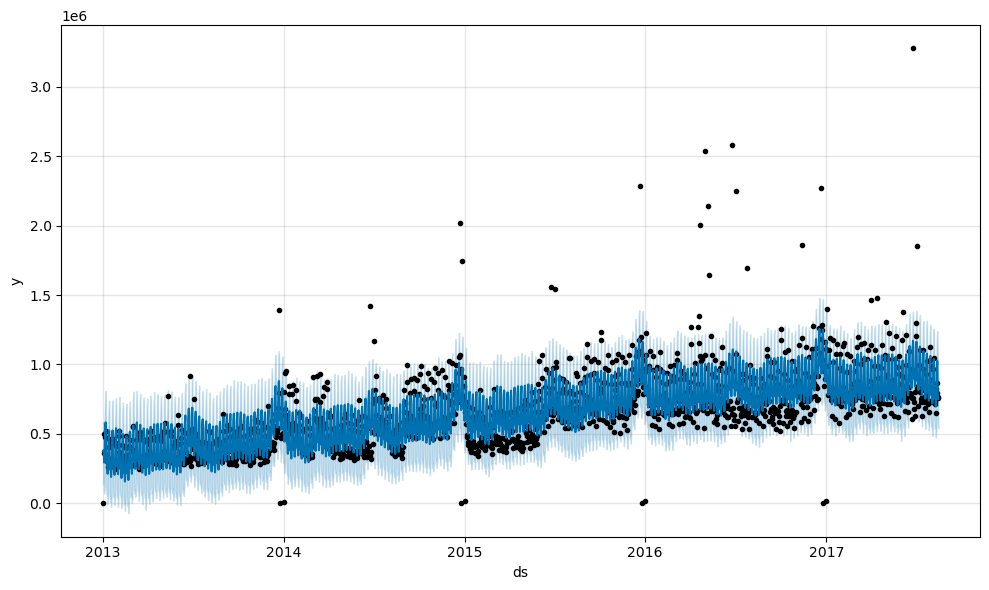

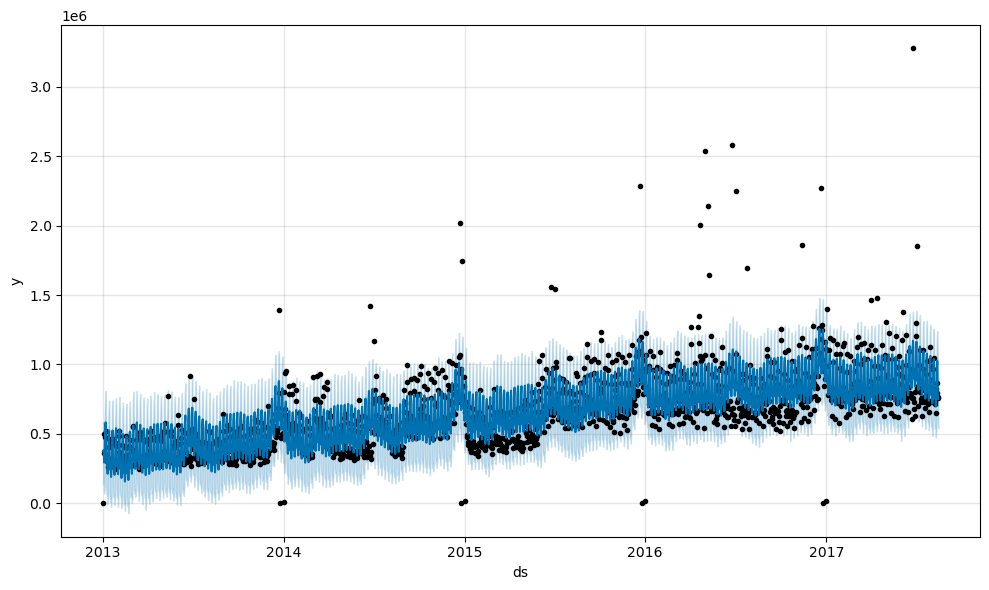

In [50]:
m.plot(forecast1)

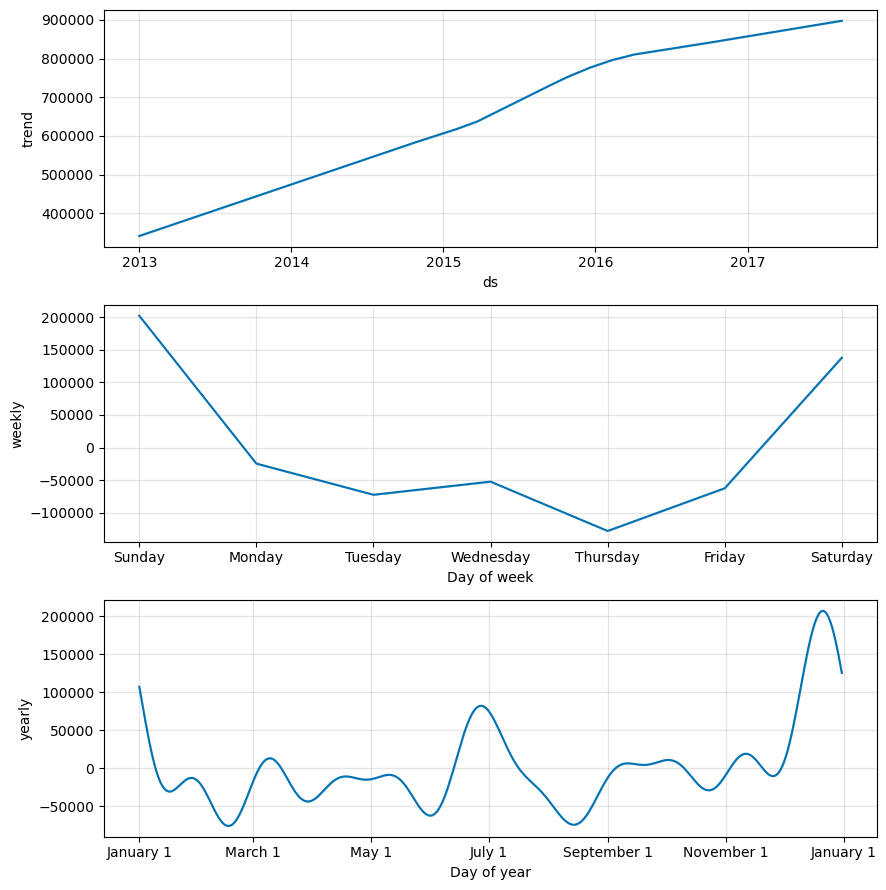

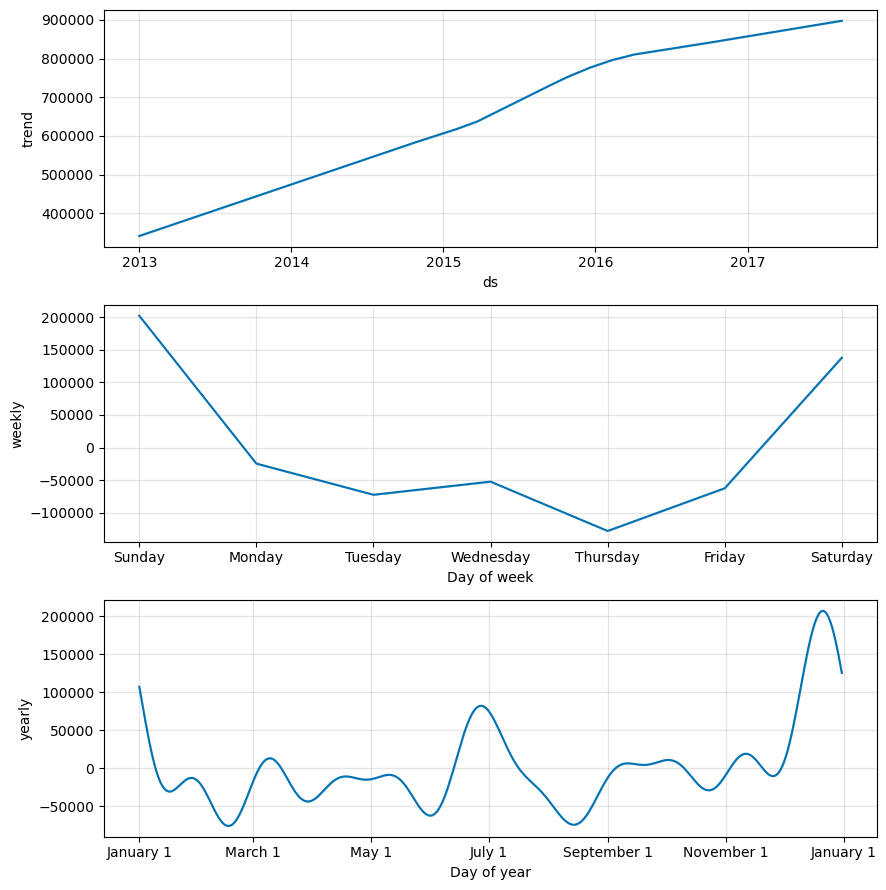

In [51]:
m.plot_components(forecast1)

### Prophet with exogenous variables

In [121]:
data = pd.DataFrame()
data = daily_sales.copy()
data = data.reset_index()
data = data.rename(columns={'sales': 'y'})
data = data.rename(columns={'date': 'ds'})
data = data[['ds', 'y', 'holiday', 'onpromotion', 'oil_price']]

In [122]:
from prophet import Prophet

m2 = Prophet()
m2.add_regressor('holiday')
m2.add_regressor('onpromotion')
m2.add_regressor('oil_price')

m2.fit(data)

22:41:51 - cmdstanpy - INFO - Chain [1] start processing
22:41:51 - cmdstanpy - INFO - Chain [1] done processing


In [124]:
# Make prediction

future = m2.make_future_dataframe(periods=16)
future['holiday'] = pd.concat([data['holiday'], daily_sales_t['holiday']], axis=0).reset_index(drop=True)
future['onpromotion'] = pd.concat([data['onpromotion'], daily_sales_t['onpromotion']], axis=0).reset_index(drop=True)
future['oil_price'] = pd.concat([data['oil_price'], daily_sales_t['oil_price']], axis=0).reset_index(drop=True)

forecast = m2.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1695,2017-08-27,1.015895e+06,837590.059340,1.211476e+06
1696,2017-08-28,7.573439e+05,570704.444925,9.435011e+05
1697,2017-08-29,7.551082e+05,565405.654861,9.394761e+05
1698,2017-08-30,1.017652e+06,844697.671467,1.213143e+06
1699,2017-08-31,7.472758e+05,562523.875993,9.344967e+05


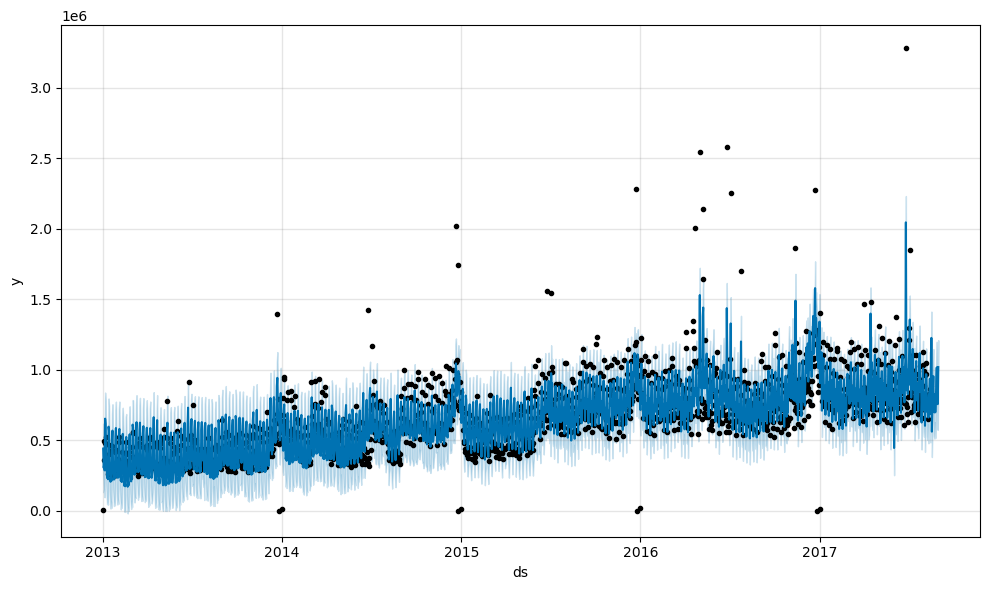

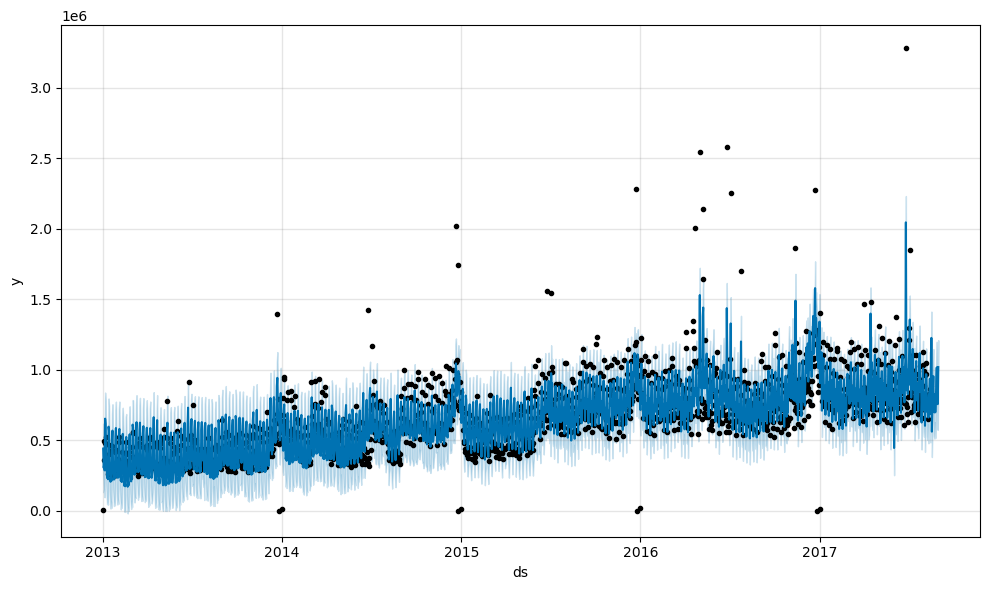

In [94]:
m.plot(forecast)

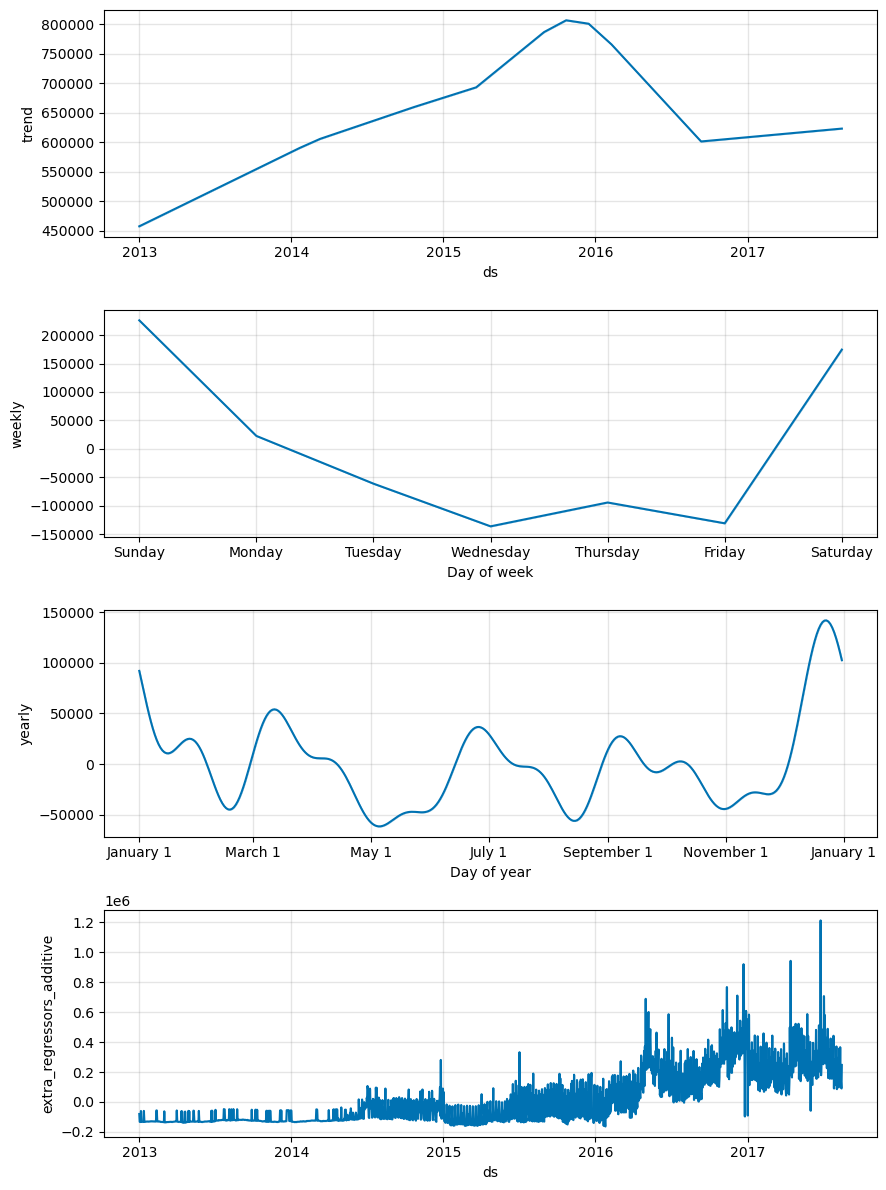

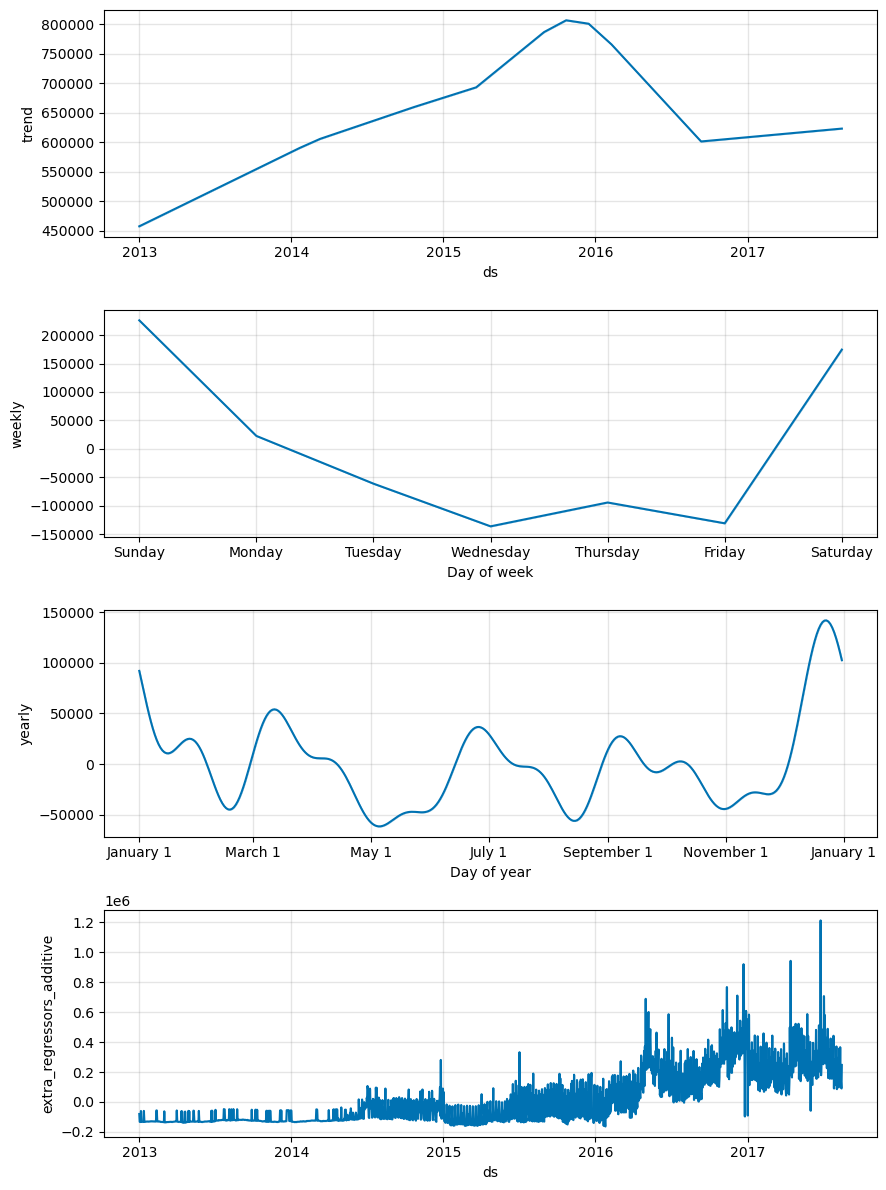

In [56]:
m.plot_components(forecast)

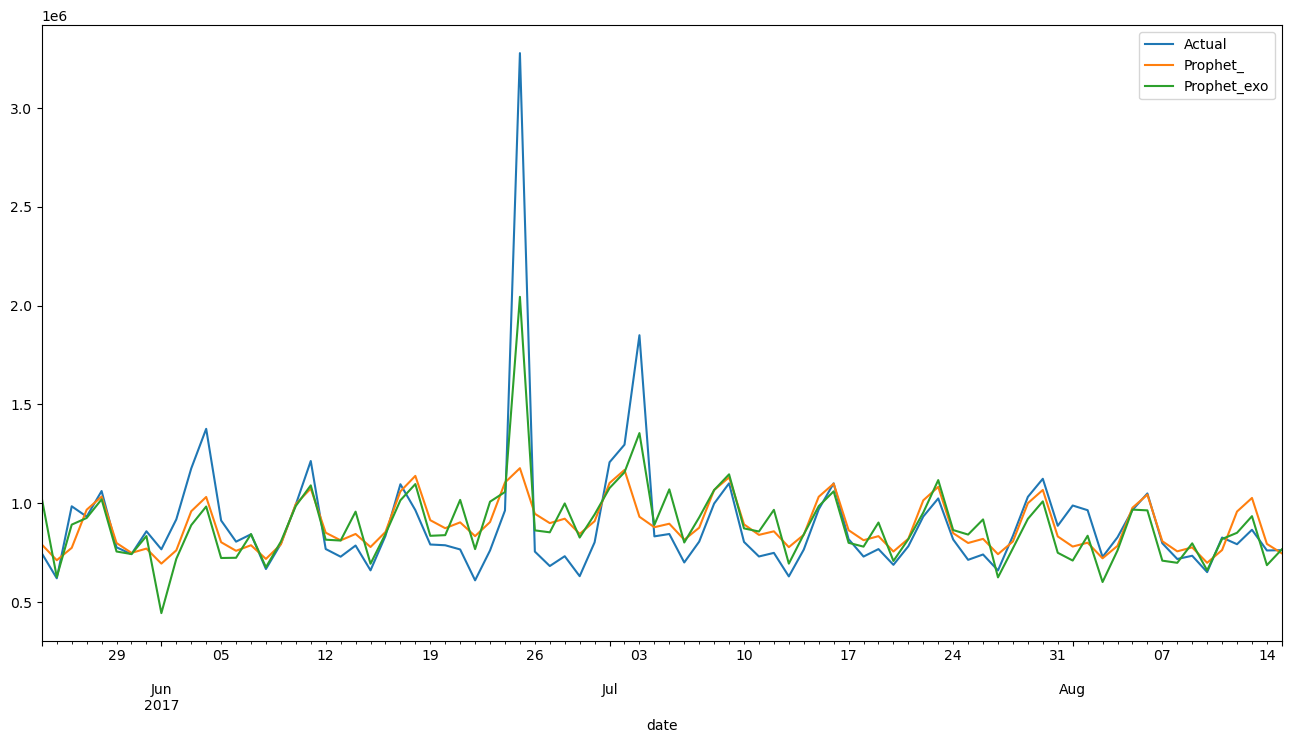

In [125]:
#Prophet with and without holiday comparison

daily_sales['forecast_2.2'] = forecast['yhat'][:-16].values

fig, ax = plt.subplots(figsize=(16, 8))
daily_sales[1600:][['sales', 'forecast_2.1', 'forecast_2.2']].plot(ax=ax);
plt.legend(['Actual', 'Prophet_', 'Prophet_exo'])
plt.show()

pred['prophet_w_exo'] = forecast['yhat'][-16:].values

It looks like Prophet prediction WITH exogenous variables gives better forecasts than the other. Let's test it.

In [104]:
# Compare both Prophet accuracy

pred_SARIMA = predicted_values
pred_Prophet = daily_sales['forecast_2.1'][-60:]
pred_Prophet_exo = daily_sales['forecast_2.2'][-60:]
actual = daily_sales['sales'][-60:]

# Define function to calculate mae, rmse

def mae(pred, actual):
    mae = np.mean(np.abs(pred - actual))
    return mae

def rmse(pred, actual):
    mse = np.mean((pred - actual) ** 2)
    rmse = np.sqrt(mse)
    return mse

def mape(pred, actual):
    absolute_percentage_errors = np.abs((actual - pred) / actual)
    mape = np.mean(absolute_percentage_errors) * 100
    return mape

data = {
    'SARIMA': [mae(pred_SARIMA, actual), rmse(pred_SARIMA, actual), mape(pred_SARIMA, actual)],
    'Prophet': [mae(pred_Prophet, actual), rmse(pred_Prophet, actual), mape(pred_Prophet, actual)],
    'Prophet_exo': [mae(pred_Prophet_exo, actual), rmse(pred_Prophet_exo, actual), mape(pred_Prophet_exo, actual)]


}

df = pd.DataFrame(data, columns=['SARIMA', 'Prophet', 'Prophet_exo'], index=['MAE', 'RMSE', 'MAPE'])
print(df)


            SARIMA       Prophet   Prophet_exo
MAE   7.402106e+04  1.353553e+05  1.239246e+05
RMSE  9.087551e+09  9.851680e+10  4.341319e+10
MAPE  8.648558e+00  1.260358e+01  1.278099e+01


For the last 60 days, it seems like  Prophet with exogenous variables performs slightly better than the other, but notice that it also depends on the chosen period.

And surprisingly SARIMA beats both of them :)))

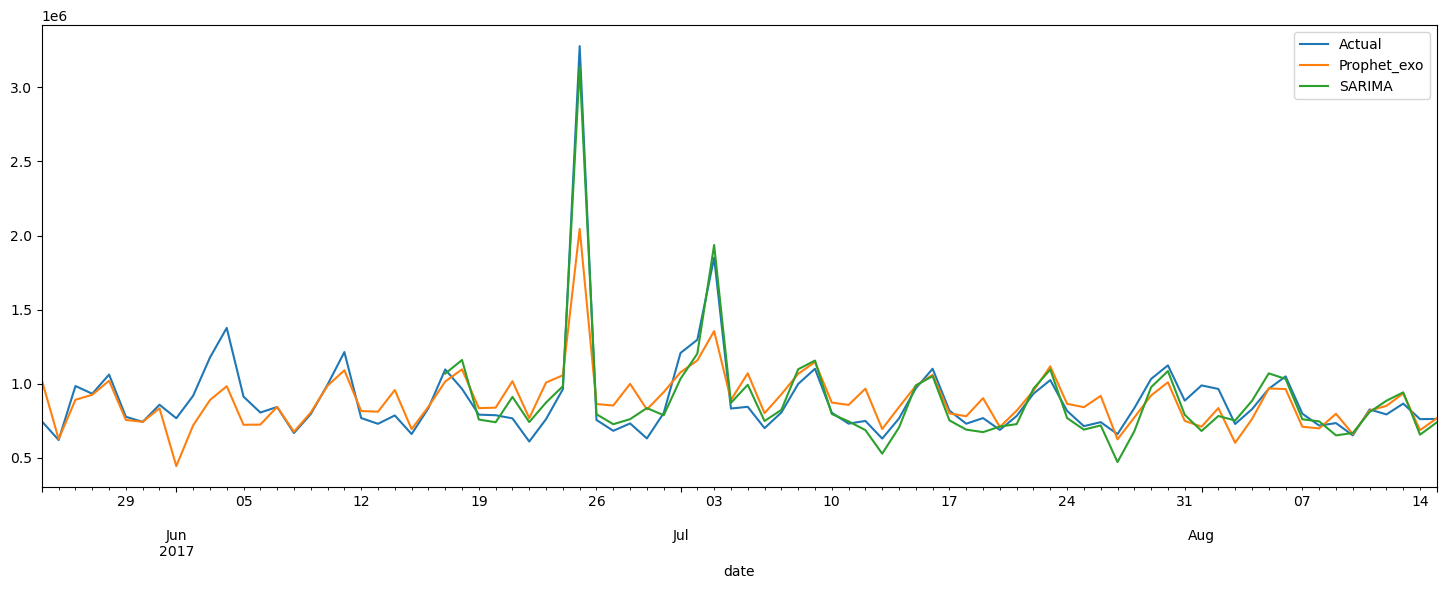

In [105]:
#SARIMA and Prophet comparison

fig, ax = plt.subplots(figsize=(18, 6))
daily_sales[1600:][['sales', 'forecast_2.2']].plot(ax=ax);
plt.plot(predicted_values.index, predicted_values, label='Forecast')
plt.legend(['Actual', 'Prophet_exo','SARIMA'])
plt.show()

# Insights:

SARIMAX model performs better than Prophet model, proving that with time series done more carefully it's worth it. 

In this case SARIMAX and Prophet perform well I don't have any issue, but we can also try LSTM too.

# Forecasting

In [126]:
pred

,sar,Prophet_wo_ex,prophet_w_exo
2017-08-16,1.721173e+06,7.703330e+05,1.224856e+06
2017-08-17,5.226257e+05,6.965391e+05,5.599838e+05
2017-08-18,6.834831e+05,7.654741e+05,7.252908e+05
2017-08-19,8.491845e+05,9.647805e+05,8.662198e+05
2017-08-20,9.378917e+05,1.038092e+06,9.533025e+05
2017-08-21,6.971614e+05,8.098655e+05,7.051547e+05
2017-08-22,6.441701e+05,7.664754e+05,6.964513e+05
2017-08-23,6.404870e+05,7.942863e+05,8.262217e+05
2017-08-24,6.159082e+05,7.240781e+05,6.971503e+05
2017-08-25,6.800225e+05,7.961423e+05,7.651803e+05


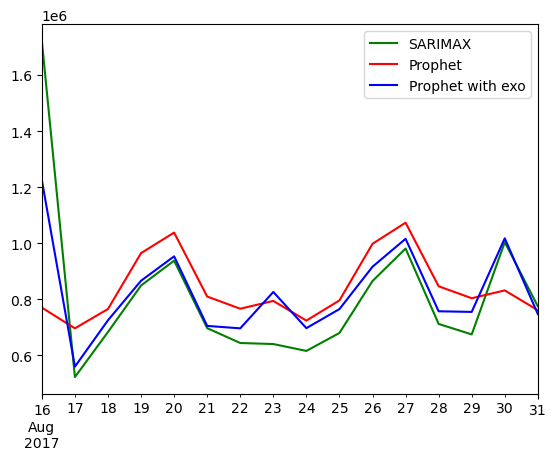

In [130]:
pred.plot(color=['green', 'red', 'blue'])
plt.legend(['SARIMAX', 'Prophet', 'Prophet with exo'])